In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../')
import adaprobe
from adaprobe.optimise.utils import sigmoid
import imageio as io
import seaborn as sns
import time

In [2]:
fontsize=14

In [5]:
dat = np.load('201118_cell1_A.npy', allow_pickle=True).item()
# img = io.imread('../Data/tiff/201118_cell1_merge2.tif')

In [6]:
cell_locs = dat['cell_locs']
order = dat['stim_order']
stimuli = dat['stimuli']
targets = dat['targets']
responses = dat['responses']

L = stimuli[:, :3]
I = stimuli[:, -1]

y = np.trapz(responses, axis=1)

In [7]:
stim_locs = L[L[:, -1] == 0][:, :2]
xmin = 194
xmax = 319

In [8]:
np.min(y)

-13.262698772858275

## Adaprobe fitting

In [81]:
# centroids = np.array([
#     [202, 296],
#     [200, 260],
#     [225, 282],
#     [241, 309],
#     [255, 290],
#     [235, 268],
#     [226, 245],
#     [242, 245],
#     [258, 235],
#     [284, 252],
#     [311, 252],
#     [300, 286],
#     [192, 215],
#     [325, 292]
# ])

In [9]:
# # centroids_withz = np.array([
# #     [202, 296, 25],
# #     [200, 260, None],
# #     [225, 282, 25],
# #     [241, 309, -25],
# #     [255, 290, None],
# #     [235, 268, None],
# #     [226, 245, -50],
# #     [242, 245, None],
# #     [258, 235, 25],
# #     [284, 252, -50],
# #     [311, 252, None],
# #     [300, 286, None],
# #     [192, 215, -75],
# #     [325, 292, None]
# # ])

# # k = 0
# depths = np.unique(cell_locs[:, 2])
# ndepths = len(depths)

# centroids_withz[centroids_withz[:, -1] == None, -1] = np.random.choice(depths, len(centroids_withz[centroids_withz[:, -1] == None]))
# centroids_withz = centroids_withz.astype(float)

In [190]:
N = len(cell_locs)

interp = 0.25

priors = {
    'alpha': 0.5 * np.ones(N),
    'omega': 5e-3 * np.ones(N),
    'mu': np.zeros(N),
    'beta': 5 * np.ones(N),
    'shape': 1,
    'rate': 1,
    'phi_map': np.c_[1e-1 * np.ones(N), 1e1 * np.ones(N)],
    'phi_cov': np.array([np.array([[1e-1, 0], [0, 1e1]]) for _ in range(N)])
}

fit_options = {
    'iters': 10,
    'newton_steps': 15, # default 10
    'lam_update': 'monte-carlo',
    'num_mc_samples': 10, # default 5
    'verbose': False,
    'init_t': 1e1,
    't_loops': 5, # default 3
    't_mult': 15,
    'interp': interp
}

ensemble_size = 5
models = [adaprobe.Model(cell_locs, priors=priors) for _ in range(ensemble_size)]
# models = [adaprobe.Model(centroids_withz, priors=priors) for _ in range(ensemble_size)]

In [191]:
K = len(y)
# K = 15000

In [192]:
def init_hist_dict(n_dicts=1, descriptors=[]):
    lsd = [{} for _ in range(n_dicts)]
    for d in lsd:
        d['utility'] = []
        for descr in descriptors:
            d[descr] = []
    if n_dicts == 1:
        return lsd[0]
    else:
        return lsd
        
def record_hist(d, umap, model, descriptors=[]):
    d['utility'] += [umap]
    for descr in descriptors:
        d[descr] += [model.state[descr]]
        
def hist_to_errs(d, sim):
    errs = {}
    w_est = (np.array(d['mu']) * np.array(d['alpha'])).T
    sigma_est = np.sqrt(np.array(d['rate'])/np.array(d['shape']))
    phi_est = np.moveaxis(np.array(d['phi_map']), 0, -1)
    
    errs['w'] = np.abs(sim.w[:, None] - w_est)
    errs['sigma'] = np.abs(sim.sigma - sigma_est)
    errs['phi_0'] = np.abs(sim.phi_0[:, None] - phi_est[:, 0, :])
    errs['phi_1'] = np.abs(sim.phi_1[:, None] - phi_est[:, 1, :])
    
    return errs

descriptors = ['mu', 'beta', 'alpha', 'lam', 'phi_map', 'phi_cov', 'shape', 'rate']

In [193]:
hist = init_hist_dict(ensemble_size, descriptors=descriptors)

# RESET SIM
for i in range(ensemble_size):
    t1 = time.time()
    for k in range(K):
        print('trial %i/%i'%(k + 1, K), end='\r')
        models[i].update(y[k], (L[k], I[k]), fit_options=fit_options, method='cavi_online_spike_and_slab')
        record_hist(hist[i], None, models[i], descriptors=descriptors)

    t2 = time.time()
    print('run %i: elapsed time %.2f'%(i, t2 - t1))

run 0: elapsed time 120.45
run 1: elapsed time 100.74
run 2: elapsed time 97.57
run 3: elapsed time 98.16
run 4: elapsed time 127.89


In [194]:
# errs_soma_ls = [hist_to_errs(hist[i], sim) for i in range(ensemble_size)]

In [195]:
# %time model.fit(y[:sample_trials], (L[:sample_trials], I[:sample_trials]), method='cavi_spike_and_slab', fit_options=fit_options)

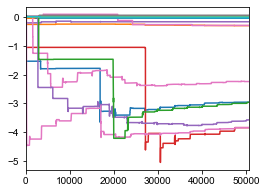

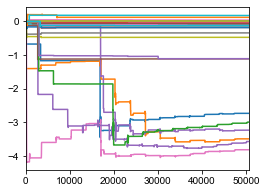

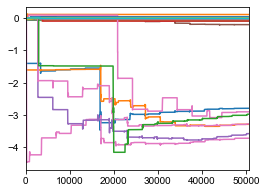

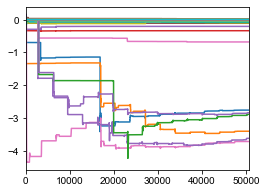

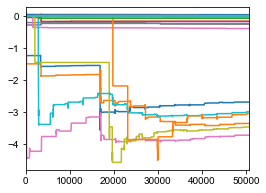

In [196]:
for i in range(ensemble_size):
    plt.figure(figsize=(4, 3))
    plt.plot(np.array(hist[i]['mu']))
    plt.xlim([0, K])
    plt.show()

In [197]:
def plot_model_hist(hist):
    plt.figure(figsize=(10, 5))
    plt.subplot(2, 3, 1)
    plt.plot(np.array(hist['mu']))
    plt.xlabel('Iterations', fontsize=fontsize-2)
    plt.ylabel('Synaptic strength mean', fontsize=fontsize-2)

    plt.subplot(2, 3, 2)
    plt.plot(np.array(hist['beta']))
    plt.xlabel('Iterations', fontsize=fontsize-2)
    plt.ylabel('Synaptic strength variance', fontsize=fontsize-2)

    plt.subplot(2, 3, 3)
    plt.plot(np.array(hist['alpha']))
    plt.xlabel('Iterations', fontsize=fontsize-2)
    plt.ylabel('Connection probability', fontsize=fontsize-2)

    plt.subplot(2, 3, 4)
    plt.plot(np.array(hist['rate'])/np.array(hist['shape']))
    plt.xlabel('Iterations', fontsize=fontsize-2)
    plt.ylabel('Noise variance', fontsize=fontsize-2)

#     plt.subplot(2, 3, 5)
#     plt.plot(np.array(hist['phi_map'])[:, :, 0])
#     plt.xlabel('Iterations', fontsize=fontsize-2)
#     plt.ylabel('phi_0', fontsize=fontsize-2)

#     plt.subplot(2, 3, 6)
#     plt.plot(np.array(['phi_map'])[:, :, 1])
#     plt.xlabel('Iterations', fontsize=fontsize-2)
#     plt.ylabel('phi_1', fontsize=fontsize-2)

    plt.tight_layout()
    plt.show()
# plt.savefig('figs/experimental_data/201118_cell1/convergence_of_model_params.png', format='png', bbox_inches='tight', dpi=200)

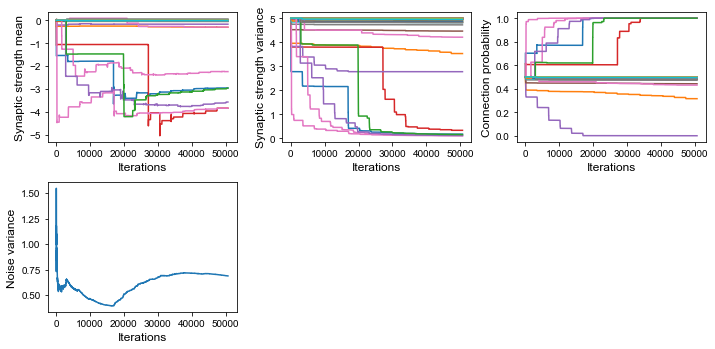

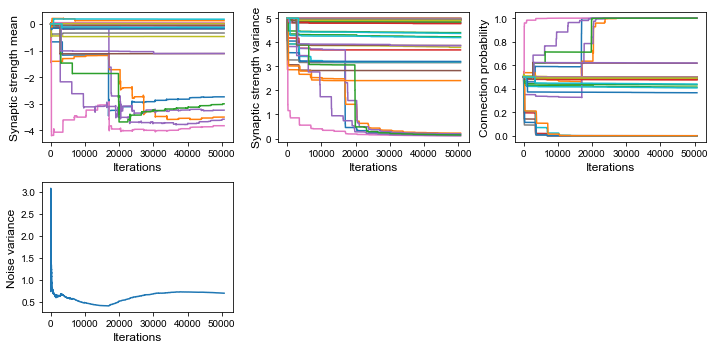

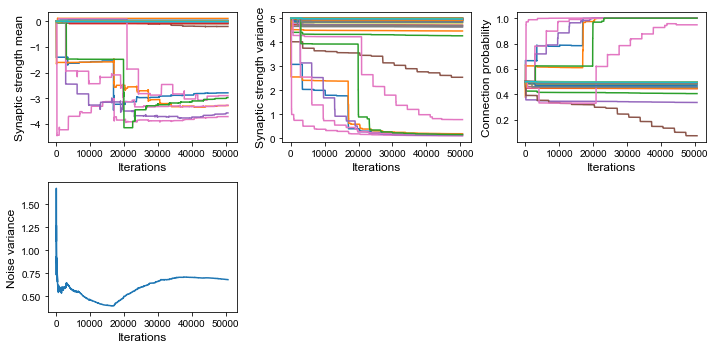

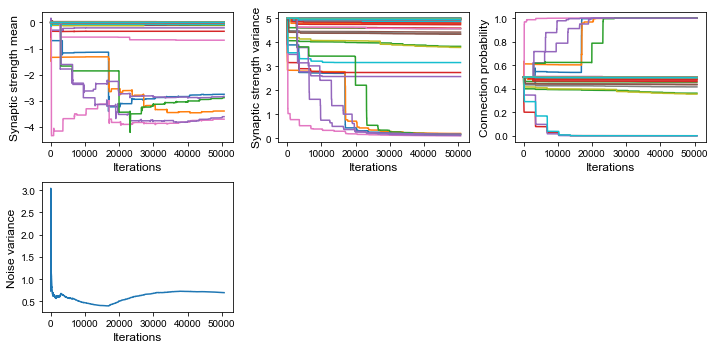

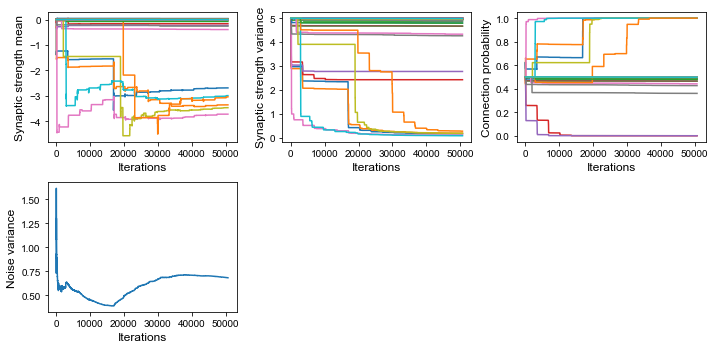

In [199]:
for i in range(ensemble_size):
    plot_model_hist(hist[i])

In [200]:
model = models[0]

In [201]:
phi_map = model.state['phi_map']
phi_cov = model.state['phi_cov']

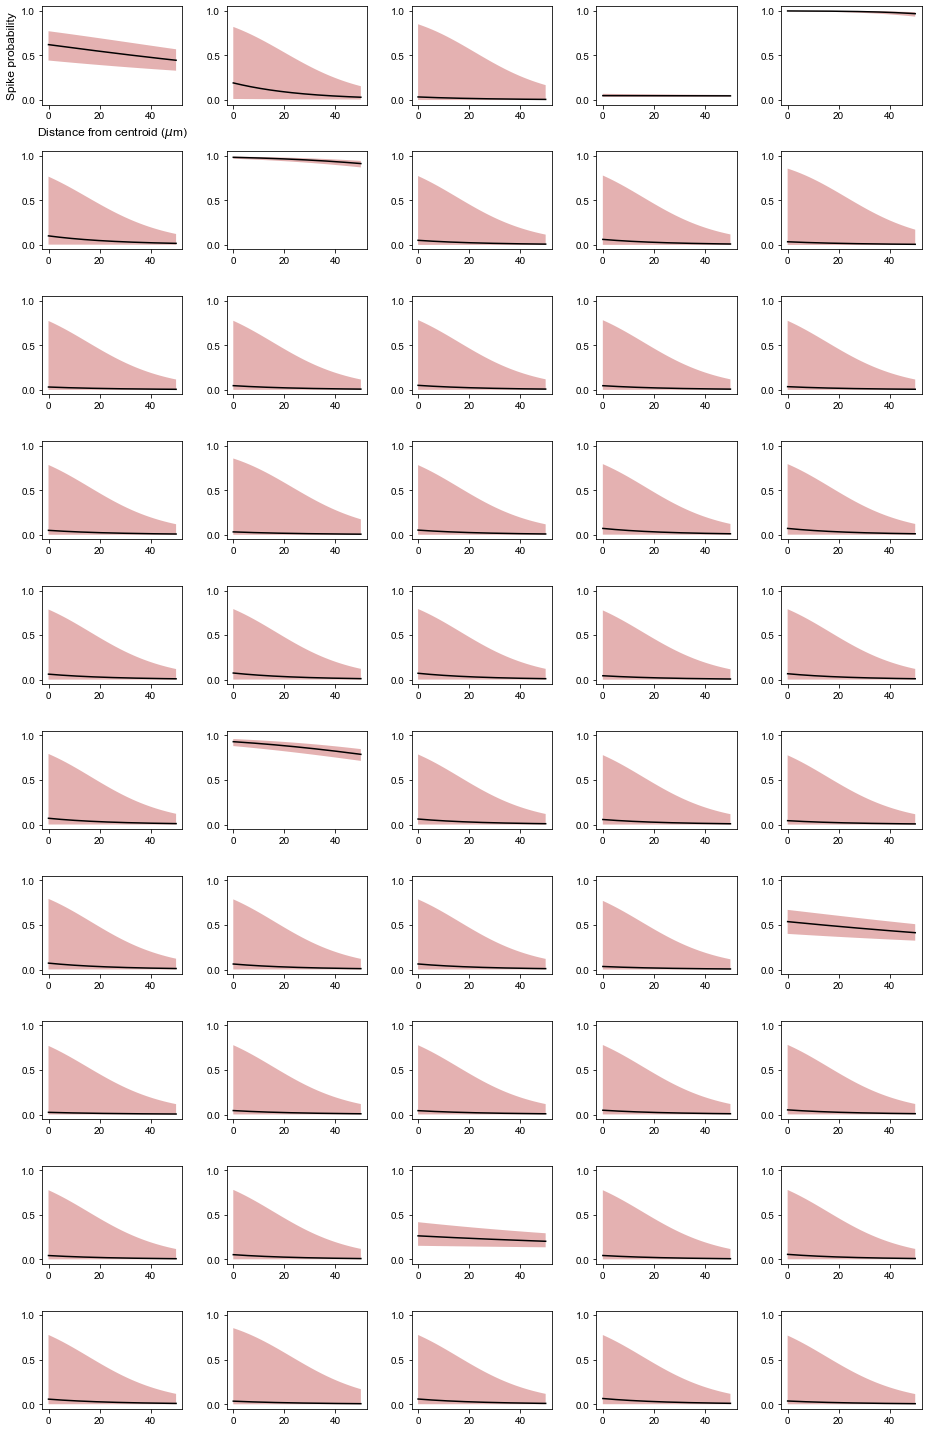

In [202]:
_power = 100
plt.figure(figsize=(13, 20))
cntr = 1
for i in range(N):
    xran = np.arange(0, 50, 0.01)
    fn = sigmoid(phi_map[i, 0] * _power * np.exp(-model.state['omega'][i] * xran) - phi_map[i, 1])
    fn_lower = sigmoid((phi_map[i, 0] - np.sqrt(phi_cov[i][0, 0])) * _power * np.exp(-model.state['omega'][i] * xran) - (phi_map[i, 1] - np.sqrt(phi_cov[i][1, 1])))
    fn_upper = sigmoid((phi_map[i, 0] + np.sqrt(phi_cov[i][0, 0])) * _power * np.exp(-model.state['omega'][i] * xran) - (phi_map[i, 1] + np.sqrt(phi_cov[i][1, 1])))
    
    plt.subplot(10, 5, cntr)
    plt.plot(xran, fn, 'k')
    plt.fill_between(xran, fn_lower, fn_upper, alpha=0.35, facecolor='firebrick', edgecolor='None')
    plt.ylim([-0.5e-1, 1 + 0.5e-1])
    if cntr == 1:
        plt.ylabel('Spike probability', fontsize=fontsize - 2)
        plt.xlabel('Distance from centroid ($\mu$m)', fontsize=fontsize - 2)
    cntr += 1
plt.tight_layout()
# plt.savefig('figs/experimental_data/example_optogenetic_rfs.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [203]:
mu = model.state['mu']
alpha = model.state['alpha']
beta = model.state['beta']
lam = np.array(model.state['lam']).T

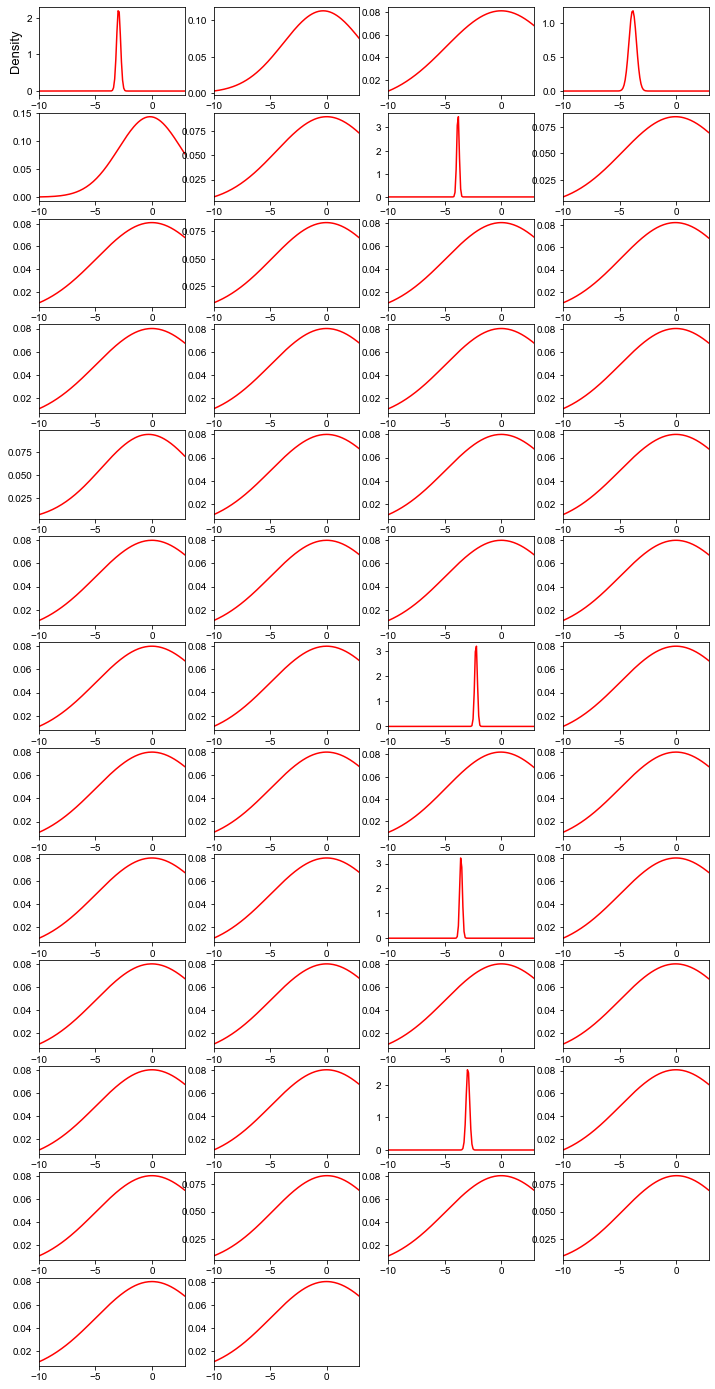

[1.    0.315 0.489 1.    0.    0.442 1.    0.472 0.492 0.481 0.493 0.484
 0.498 0.496 0.495 0.497 0.43  0.499 0.498 0.498 0.499 0.499 0.498 0.498
 0.498 0.499 1.    0.497 0.499 0.496 0.486 0.498 0.497 0.498 1.    0.498
 0.498 0.497 0.498 0.495 0.498 0.495 1.    0.494 0.498 0.482 0.494 0.482
 0.498 0.494]


In [204]:
xrange = np.arange(-10, 3, 0.1)
def gaussf(mean, sdev):
    return 1/(np.sqrt(2 * np.pi * sdev**2)) * np.exp(-1/(2 * sdev**2) * (xrange - mean)**2)

plt.figure(figsize=(12, 2*(N/4)))
for n in range(N):
    plt.subplot(int(np.ceil(N/4)), 4, n + 1)
    post = gaussf(mu[n], beta[n])
    plt.plot(xrange, post, color='r')
    plt.xlim(np.min(xrange), np.max(xrange))
    if n == 0:
        plt.ylabel('Density', fontsize=fontsize-1)
plt.show()
# plt.savefig('figs/example_burnin_inference.png', format='png', bbox_inches='tight')

print(np.round(alpha, 3))

In [205]:
np.round(mu, 2)

array([-2.95, -0.31, -0.  , -3.83, -0.17,  0.01, -3.84, -0.04, -0.01,
       -0.02,  0.01, -0.05, -0.  , -0.01, -0.  , -0.  , -0.3 , -0.  ,
       -0.  , -0.  , -0.  ,  0.  , -0.  , -0.  , -0.  ,  0.  , -2.24,
        0.  , -0.  ,  0.  , -0.05, -0.  ,  0.  , -0.  , -3.57,  0.  ,
       -0.02,  0.  ,  0.  , -0.03, -0.  , -0.01, -2.96, -0.01, -0.  ,
        0.03, -0.  ,  0.05,  0.  , -0.01])

In [206]:
model.state['rate']/model.state['shape']

0.6878192878616296

In [224]:
model = models[0]

In [225]:
from sklearn.metrics import r2_score
y_pred = np.sum(model.state['mu'][:, None] * model.state['alpha'][:, None] * np.array(model.state['lam']).T, 0)

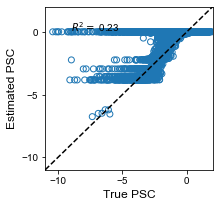

In [226]:
plt.figure(figsize=(3, 3))
plt.scatter(y[:K], y_pred, facecolor='None', edgecolor='C0')
plt.plot([-11, 2], [-11, 2], '--', color='k')
plt.xlim([-11, 2])
plt.ylim([-11, 2])
plt.text(-9, 0, '$R^2 =$ %.2f'%r2_score(y[:K], y_pred))
plt.xticks([-10, -5, 0])
plt.yticks([-10, -5, 0])
plt.xlabel('True PSC', fontsize=fontsize-2)
plt.ylabel('Estimated PSC', fontsize=fontsize-2)
# plt.savefig('figs/experimental_data/201118_cell1/estimated_vs_true_psps.png', format='png', dpi=250, bbox_inches='tight')
plt.show()

In [250]:
len(yr)

100

In [251]:
len(xr)

135

In [ ]:
# vmin = np.min([np.min(pred_maps[indx]) for indx in range(self.num_planes)])
# vmax = np.max([np.max(pred_maps[indx]) for indx in range(self.num_planes)])

# plot.contourf(self.gridx, self.gridy, pred_maps[indx].reshape(self.yr, self.xr), CONTOUR_NUM, cmap='viridis_r', vmin=vmin, vmax=vmax)
# cell_ids_on_plane = np.where(self.cell_locs[:, 2] == self.planes[indx])[0]
# cell_locs_on_plane = self.cell_locs[cell_ids_on_plane, :2]
# plot.scatter(cell_locs_on_plane[:, 0], cell_locs_on_plane[:, 1], marker='x', color='r')

# for n in cell_ids_on_plane:
#     plot.text(self.cell_locs[n, 0], self.cell_locs[n, 1], str(n + 1), color='red', fontsize=FONTSIZE)

In [271]:
curr_plane = cell_locs[np.where(cell_locs[:, -1] == 0)[0]]
xgrid, ygrid, xr, yr = adaprobe.simulation._generate_grid(cell_locs[:, :2], spacing=10, grid_density=1)
grid = np.c_[xgrid.flatten(), ygrid.flatten()]
pred_map = adaprobe.experimental_design.posterior_predictive_map_on_plane(grid, -75, 70, models[1], n_samples=10)

plt.imshow(pred_map.reshape([len(yr), len(xr)]))
plt.colorbar()

In [227]:
example_len = 1500
st = 20250
stp = st + example_len

In [228]:
from matplotlib import gridspec
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1]) 

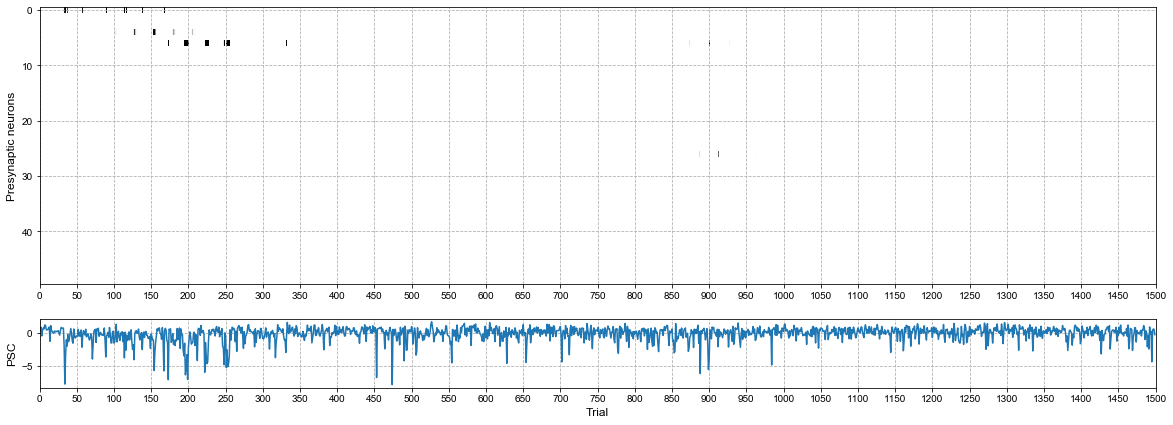

In [229]:
plt.figure(figsize=(20, 7))
plt.subplot(gs[0])
plt.imshow(lam[:, st:stp], aspect='auto', cmap='gray_r')
plt.xlim([0, example_len])
plt.xticks(np.arange(0, example_len+1, 50))
plt.grid(linestyle='--')
plt.ylabel('Presynaptic neurons', fontsize=fontsize-2)

plt.subplot(gs[1])
plt.plot(y[st:stp])
plt.xlim([0, example_len])
plt.grid(linestyle='--')
plt.xticks(np.arange(0, example_len+1, 50))
plt.xlabel('Trial', fontsize=fontsize-2)
plt.ylabel('PSC', fontsize=fontsize-2)

# plt.savefig('figs/experimental_data/201118_cell1/inferred_presynaptic_activity.png', format='png', bbox_inches='tight', dpi=200)
plt.show()

In [ ]:
plt.figure(figsize=(20, 7))
plt.subplot(gs[0])
plt.imshow(lam, aspect='auto', cmap='gray_r')
plt.xlim([0, len(y)])
plt.grid(linestyle='--')
plt.ylabel('Presynaptic neurons', fontsize=fontsize-2)

plt.subplot(gs[1])
plt.plot(y)
plt.xlim([0, len(y)])
plt.grid(linestyle='--')
plt.xlabel('Trial', fontsize=fontsize-2)
plt.ylabel('PSC', fontsize=fontsize-2)

# plt.savefig('figs/experimental_data/inferred_presynaptic_activity_all_trials.png', format='png', bbox_inches='tight', dpi=200)
plt.show()

In [ ]:
plt.figure(figsize=(20, 7))
plt.imshow(lam, aspect='auto', cmap='gray_r')
plt.xlim([0, len(y)])
# plt.xticks(np.arange(0, example_len+1, 50))
plt.grid(linestyle='--')
plt.ylabel('Inferred presynaptic spikes', fontsize=fontsize-2)
plt.show()

plt.figure(figsize=(20, 1))
plt.plot(y)
plt.xlim([0, len(y)])
plt.grid(linestyle='--')
# plt.xticks(np.arange(0, example_len+1, 50))
plt.xlabel('Trial', fontsize=fontsize-2)
plt.ylabel('PSP', fontsize=fontsize-2)
plt.show()

In [ ]:
for n in range(N):
    plt.figure(figsize=(15, 0.25))
    plt.plot(lam[n, st:stp])
#     plt.xlim([st, stp])
    plt.ylim([0, 1])
    plt.axis('off')
    plt.show()

## Comparison with lasso maps

In [273]:
from scipy.sparse import csc_matrix
from sklearn.linear_model import Lasso

In [274]:
nstim = len(targets)

ntrials_to_include = int(stimuli.shape[0]/targets.shape[0])
row = np.array(range(nstim * ntrials_to_include))
col = np.array(list(range(nstim)) * ntrials_to_include)
sp_data = np.ones(len(col))

A = csc_matrix((sp_data, (row, col)))

In [275]:
alpha = 1e-4
sparse_lasso = Lasso(alpha=alpha, fit_intercept=False, max_iter=1000)
sparse_lasso.fit(A, y)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [276]:
b_sp = sparse_lasso.coef_

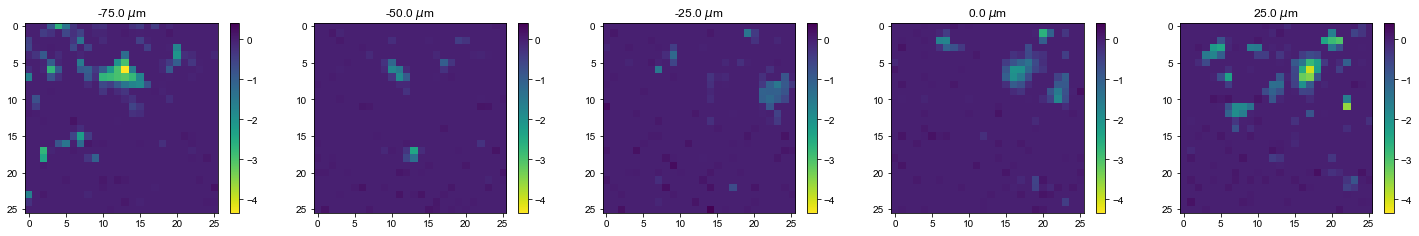

In [295]:
plt.figure(figsize=(ndepths*5, 3.5))
vmin = np.min(b_sp)
vmax = np.max(b_sp)
for indx, loc in enumerate(depths):
    tar_plane = np.where(targets[:, -1] == loc)[0]
    tars = targets[tar_plane]
    plt.subplot(1, 5, indx + 1)
    plt.title(str(loc) + ' $\mu$m')
    plt.imshow(b_sp[tar_plane].reshape([26, 26]), cmap='viridis_r', aspect='auto', vmin=vmin, vmax=vmax)
    plt.colorbar()
plt.show()

In [ ]:
curr_plane = cell_locs[np.where(cell_locs[:, -1] == 0)[0]]
xgrid, ygrid, xr, yr = adaprobe.simulation._generate_grid(cell_locs[:, :2], spacing=10, grid_density=1)
grid = np.c_[xgrid.flatten(), ygrid.flatten()]

In [ ]:
pred_maps_50_mw = [adaprobe.experimental_design.posterior_predictive_map_on_plane(grid, d, 50, models[0], n_samples=50) for d in depths]
pred_maps_70_mw = [adaprobe.experimental_design.posterior_predictive_map_on_plane(grid, d, 70, models[0], n_samples=50) for d in depths]

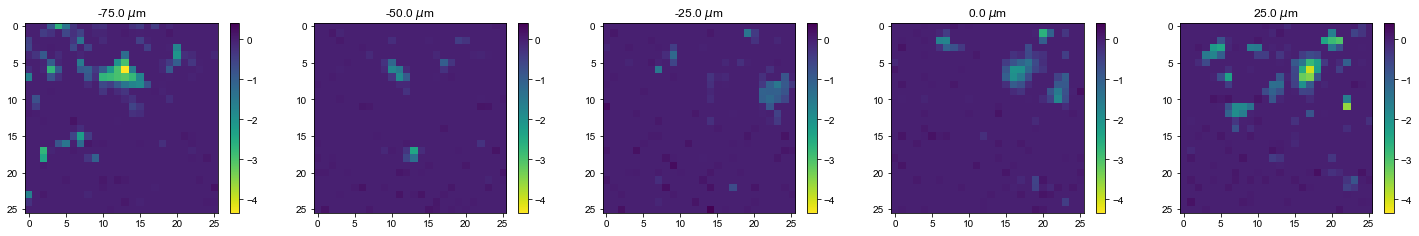

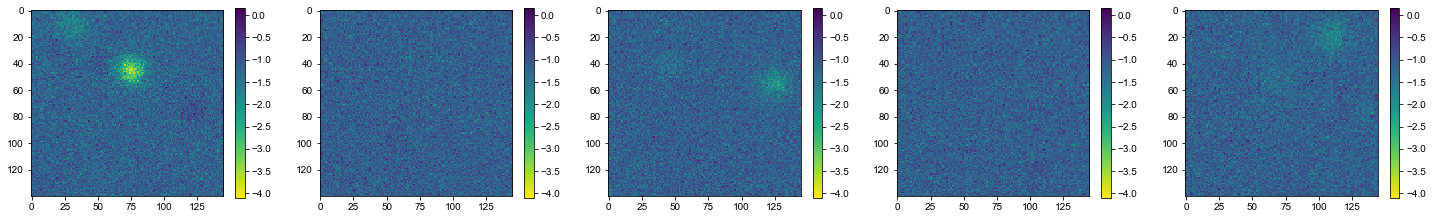

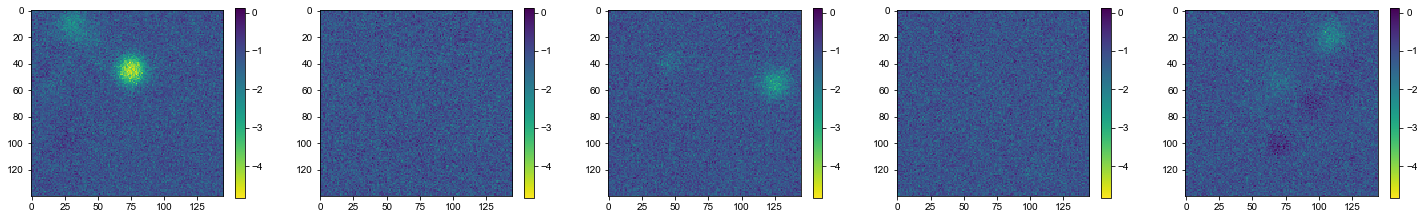

In [316]:
plt.figure(figsize=(ndepths*5, 3.5))
vmin = np.min(b_sp)
vmax = np.max(b_sp)
for indx, loc in enumerate(depths):
    tar_plane = np.where(targets[:, -1] == loc)[0]
    tars = targets[tar_plane]
    plt.subplot(1, 5, indx + 1)
    plt.title(str(loc) + ' $\mu$m')
    plt.imshow(b_sp[tar_plane].reshape([26, 26]), cmap='viridis_r', aspect='auto', vmin=vmin, vmax=vmax)
    plt.colorbar()
plt.show()

vmin = np.min(pred_maps_50_mw)
vmax = np.max(pred_maps_50_mw)
plt.figure(figsize=(ndepths*5, 3.5))
for i in range(len(depths)):
    plt.subplot(1, ndepths, i + 1)
    plt.imshow(pred_maps_50_mw[i].reshape([len(yr), len(xr)]).T, cmap='viridis_r', vmin=vmin, vmax=vmax)
    plt.colorbar()
plt.show()

vmin = np.min(pred_maps_70_mw)
vmax = np.max(pred_maps_70_mw)
plt.figure(figsize=(ndepths*5, 3.5))
for i in range(len(depths)):
    plt.subplot(1, ndepths, i + 1)
    plt.imshow(pred_maps_70_mw[i].reshape([len(yr), len(xr)]).T, cmap='viridis_r', vmin=vmin, vmax=vmax)
    plt.colorbar()
plt.show()

In [279]:
two_d_locs = targets[targets[:, 2] == 0, :2]

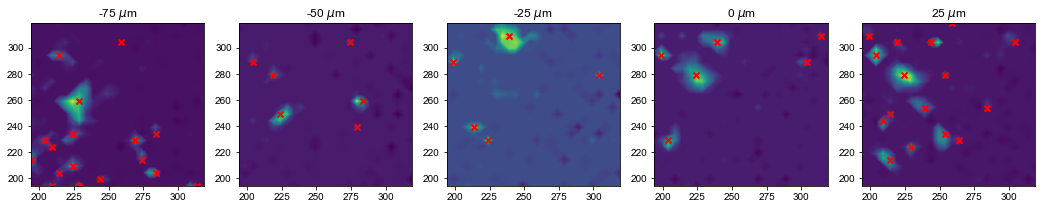

In [280]:
plt.figure(figsize=(18, 3))
for indx, d in enumerate(depths):
    plt.subplot(1, ndepths, indx + 1)
    tar_plane = np.where(targets[:, -1] == d)[0]
    tars = targets[tar_plane]
    plt.title(str(int(d)) + ' $\mu$m')
    plt.contourf(np.unique(two_d_locs[:, 0]), np.unique(two_d_locs[:, 1]), b_sp[tar_plane].reshape([26, 26]).T, 200, cmap='viridis_r')
    cells_on_plane = cell_locs[cell_locs[:, -1] == d, :2]
    stim_locs_on_plane = np.where(L[:, -1] == d)[0]
    plt.scatter(cells_on_plane[:, 0], cells_on_plane[:, 1], marker='x', color='r', linewidth=2)
    plt.xlim([xmin, xmax])
    plt.ylim([xmin, xmax])
# plt.savefig('figs/experimental_data/putative_cell_locations.png', format='png', dpi=250, bbox_inches='tight')
plt.show()

In [ ]:
hotspot_ord = np.argsort(model.state['mu'] * model.state['alpha'])
hotspots = hotspot_ord[:15]

In [ ]:
plt.figure(figsize=(18, 7))
cntr = 1
for indx, d in enumerate(depths):
    plt.subplot(2, ndepths, cntr)
    tar_plane = np.where(targets[:, -1] == d)[0]
    tars = targets[tar_plane]
    plt.title(str(int(d)) + ' $\mu$m')
    plt.contourf(np.unique(two_d_locs[:, 0]), np.unique(two_d_locs[:, 1]), b_sp[tar_plane].reshape([26, 26]).T, 200, cmap='viridis_r')
    cells_on_plane = cell_locs[cell_locs[:, -1] == d, :2]
    stim_locs_on_plane = np.where(L[:, -1] == d)[0]
    plt.scatter(cells_on_plane[:, 0], cells_on_plane[:, 1], marker='x', color='r', linewidth=2)
    plt.xlim([xmin, xmax])
    plt.ylim([xmin, xmax])
    cntr += 1
    if indx == 0:
        plt.ylabel('All presynaptic ROIs', fontsize=fontsize-2)

for indx, d in enumerate(depths):
    plt.subplot(2, ndepths, cntr)
    tar_plane = np.where(targets[:, -1] == d)[0]
    tars = targets[tar_plane]
    plt.title(str(int(d)) + ' $\mu$m')
    plt.contourf(np.unique(two_d_locs[:, 0]), np.unique(two_d_locs[:, 1]), b_sp[tar_plane].reshape([26, 26]).T, 200, cmap='viridis_r')
    cells_on_plane = cell_locs[hotspots[cell_locs[hotspots, -1] == d], :2]
    plt.scatter(cells_on_plane[:, 0], cells_on_plane[:, 1], marker='x', color='white', linewidth=2)
    plt.xlim([xmin, xmax])
    plt.ylim([xmin, xmax])
    cntr += 1
    if indx == 0:
        plt.ylabel('Most active ROIs', fontsize=fontsize-2)
    
# plt.savefig('figs/experimental_data/putative_cell_locations_with_presynaptic_activity.png', format='png', dpi=250, bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize=(25, 10))
cntr = 1
for indx, d in enumerate(depths):
    plt.subplot(2, ndepths, cntr)
    tar_plane = np.where(targets[:, -1] == d)[0]
    tars = targets[tar_plane]
    plt.title(str(int(d)) + ' $\mu$m')
    plt.contourf(np.unique(two_d_locs[:, 0]), np.unique(two_d_locs[:, 1]), b_sp[tar_plane].reshape([26, 26]).T, 200, cmap='viridis_r')
    cells_on_plane = cell_locs[cell_locs[:, -1] == d, :2]
    stim_locs_on_plane = np.where(L[:, -1] == d)[0]
    plt.scatter(cells_on_plane[:, 0], cells_on_plane[:, 1], marker='x', color='r', linewidth=2)
    plt.xlim([xmin, xmax])
    plt.ylim([xmin, xmax])
    cntr += 1
    if indx == 0:
        plt.ylabel('All presynaptic ROIs', fontsize=fontsize-2)

In [ ]:
titles = ['red channel', 'green channel']
plt.figure(figsize=(10, 5))
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(img[:, :, i])
    plt.title(titles[i])
    for d in depths:
        cells_on_plane = cell_locs[cell_locs[:, -1] == d, :2]
        stim_locs_on_plane = np.where(L[:, -1] == d)[0]
        plt.scatter(cells_on_plane[:, 0], cells_on_plane[:, 1], marker='x', color='r', linewidth=2)
    plt.xlim([xmin, xmax])
    plt.ylim([xmin, xmax])
plt.show()

In [ ]:
b_sp_flat = np.zeros((26, 26))
for d in depths:
    tar_plane = np.where(targets[:, -1] == d)[0]
    tars = targets[tar_plane]
    b_sp_flat += b_sp[tar_plane].reshape([26, 26])
b_sp_flat /= ndepths

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img[:, :, 1])
for d in depths:
    cells_on_plane = cell_locs[cell_locs[:, -1] == d, :2]
    stim_locs_on_plane = np.where(L[:, -1] == d)[0]
    plt.scatter(cells_on_plane[:, 0], cells_on_plane[:, 1], marker='x', color='r', linewidth=2)
plt.xlim([xmin, xmax])
plt.ylim([xmin, xmax])

plt.subplot(1, 2, 2)
plt.contourf(np.unique(two_d_locs[:, 0]), np.unique(two_d_locs[:, 1]), b_sp_flat.T, 200, cmap='viridis_r')
# plt.imshow(b_sp_flat.T, cmap='viridis_r', origin='lower')
for d in depths:
    cells_on_plane = cell_locs[cell_locs[:, -1] == d, :2]
    stim_locs_on_plane = np.where(L[:, -1] == d)[0]
    plt.scatter(cells_on_plane[:, 0], cells_on_plane[:, 1], marker='x', color='r', linewidth=2)
plt.xlim([xmin, xmax])
plt.ylim([xmin, xmax])
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img[:, :, 0], origin='upper')
for d in depths:
    cells_on_plane = cell_locs[cell_locs[:, -1] == d, :2]
    stim_locs_on_plane = np.where(L[:, -1] == d)[0]
    plt.scatter(cells_on_plane[:, 0], cells_on_plane[:, 1], marker='x', color='r', linewidth=2)
plt.xlim([xmin, xmax])
plt.ylim([xmin, xmax])

plt.subplot(1, 2, 2)
plt.contourf(np.unique(two_d_locs[:, 0]), np.unique(two_d_locs[:, 1]), b_sp_flat.T, 200, cmap='viridis_r')
# plt.imshow(b_sp_flat.T, cmap='viridis_r', origin='lower')
for d in depths:
    cells_on_plane = cell_locs[cell_locs[:, -1] == d, :2]
    plt.scatter(cells_on_plane[:, 0], cells_on_plane[:, 1], marker='x', color='r', linewidth=2)
plt.xlim([xmin, xmax])
plt.ylim([xmin, xmax])
plt.show()

In [ ]:
plt.figure(figsize=(16, 8))
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(img[:, :, i])
    plt.scatter(stim_locs[:, 0], stim_locs[:, 1], 20, marker='x', color='white')
    for d in depths:
        cells_on_plane = cell_locs[cell_locs[:, -1] == d, :2]
        plt.scatter(cells_on_plane[:, 0], cells_on_plane[:, 1], marker='x', color='r', linewidth=2)
    plt.title(titles[i])
    plt.xlim([xmin - 10, xmax + 10])
    plt.ylim([xmin - 10, xmax + 10])
plt.show()

In [ ]:
plt.figure(figsize=(13, 6))
plt.subplot(1, 2, 1)
plt.imshow(img[:, :, 1])
plt.scatter(stim_locs[:, 0], stim_locs[:, 1], 20, marker='x', color='white')
for d in depths:
    cells_on_plane = cell_locs[cell_locs[:, -1] == d, :2]
    plt.scatter(cells_on_plane[:, 0], cells_on_plane[:, 1], marker='x', color='r', linewidth=2)
plt.xlim([xmin - 10, xmax + 10])
plt.ylim([xmin - 10, xmax + 10])


plt.subplot(1, 2, 2)
plt.contourf(np.unique(two_d_locs[:, 0]), np.unique(two_d_locs[:, 1]), b_sp_flat.T, 100, cmap='viridis_r')
# plt.imshow(img[:, :, 1], cmap='gray')
for d in depths:
    cells_on_plane = cell_locs[cell_locs[:, -1] == d, :2]
    plt.scatter(cells_on_plane[:, 0], cells_on_plane[:, 1], marker='x', color='r', linewidth=2)
plt.xlim([xmin, xmax])
plt.ylim([xmin, xmax])
plt.show()

In [ ]:
dim = 512
x_diff = -5
y_diff = -8

img_xlate = np.zeros((dim, dim))
img_xlate[:dim + x_diff, -y_diff:] = img[-x_diff:, :dim + y_diff, 1]

In [ ]:
# hotspot_ord

In [ ]:
plane_depth = 0
curr_plane = cell_locs[cell_locs[:, -1] == plane_depth, :2]
power = 100

xgrid, ygrid, xr, yr = adaprobe.simulation._generate_grid(curr_plane, spacing=30, grid_density=1)
grid = np.c_[xgrid.flatten(), ygrid.flatten()]

def get_receptive_field(n):
    return sigmoid(model.state['phi_map'][n][0] * power \
          * np.exp(-model.state['omega'][n] * np.sum(np.square(centroids_withz[n][:2] - grid), 1)) - model.state['phi_map'][n, 1])

In [ ]:
# spk_map = get_receptive_field(6)
mu_thresh = -1
plt.figure(figsize=(8, 7))
for n in range(N):
    if mu[n] < mu_thresh:
        plt.contour(xgrid, ygrid, get_receptive_field(n).reshape(len(yr), len(xr)), 150, alpha=0.15)
plt.imshow(img_xlate, cmap='gray')
plt.scatter(stim_locs[:, 0], stim_locs[:, 1], 20, marker='x', color='C0', alpha=0.1)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', color='r')
plt.xlim([xmin - 10, xmax + 10])
plt.ylim([xmin - 10, xmax + 10])
# plt.savefig('figs/experimental_data/201118_cell1/receptive_fields.png', format='png', bbox_inches='tight', dpi=200)
plt.show()

In [ ]:
plt.figure(figsize=(8, 7))
for n in range(N):
    if mu[n] < mu_thresh:
        plt.contour(xgrid, ygrid, get_receptive_field(n).reshape(len(yr), len(xr)), 150, alpha=0.15)
plt.imshow(img_xlate, cmap='gray')
plt.xlim([50, 500])
plt.ylim([100, 450])
# plt.savefig('figs/experimental_data/201118_cell1/receptive_fields_zoomed_out.png', format='png', bbox_inches='tight', dpi=200)
plt.show()

In [ ]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(img[:, :, 1])
plt.scatter(stim_locs[:, 0], stim_locs[:, 1], 20, marker='x', color='white')
for d in depths:
    cells_on_plane = cell_locs[cell_locs[:, -1] == d, :2]
    plt.scatter(cells_on_plane[:, 0], cells_on_plane[:, 1], marker='x', color='r', linewidth=2)
plt.xlim([xmin - 10, xmax + 10])
plt.ylim([xmin - 10, xmax + 10])
plt.title('Stim locations')

plt.subplot(1, 2, 2)
contourf = plt.contourf(np.unique(two_d_locs[:, 0]), np.unique(two_d_locs[:, 1]), b_sp_flat.T, 50, cmap='viridis_r')
for d in depths:
    cells_on_plane = cell_locs[cell_locs[:, -1] == d, :2]
    plt.scatter(cells_on_plane[:, 0], cells_on_plane[:, 1], marker='x', color='r', linewidth=2)
plt.xlim([xmin, xmax])
plt.ylim([xmin, xmax])
plt.title('LASSO map (contourf)')

# plt.savefig('figs/experimental_data/tissue_movement/fig1.png', format='png', bbox_inches='tight', dpi=200)
plt.show()

In [ ]:
xmax - xmin

In [ ]:
np.unique(two_d_locs[:, 0])

In [ ]:
img_cropped = img[xmin+10:xmax+10, xmin-10:xmax-10, 1]
img_cropped_noshift = img[xmin:xmax, xmin:xmax, 1]

In [ ]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(b_sp_flat.reshape([26, 26]).T, cmap='viridis_r', origin='lower')
plt.title('LASSO map (pixel-wise)')
plt.subplot(1, 3, 2)
plt.imshow(img_cropped, origin='lower')
plt.title('GFP+ChroME nuclear channel (translated (+10, -10))')
plt.subplot(1, 3, 3)
plt.imshow(img_cropped_noshift, origin='lower')
plt.title('GFP+ChroME nuclear channel (raw)')

# plt.savefig('figs/experimental_data/tissue_movement/fig2.png', format='png', bbox_inches='tight', dpi=200)
plt.show()

In [ ]:
plt.figure(figsize=(6, 6))
plt.imshow(b_sp_flat.reshape([26, 26]).T, cmap='viridis_r', origin='lower')
plt.title('LASSO map (pixel-wise)')
# plt.savefig('figs/experimental_data/201118_cell1/lasso_map.png', format='png', bbox_inches='tight', dpi=200)
plt.show()

In [ ]:
plt.figure(figsize=(21, 6))
plt.subplot(1, 3, 1)
plt.imshow(img[:, :, 1])
# plt.scatter(stim_locs[:, 0], stim_locs[:, 1], 20, marker='x', color='white')
for d in depths:
    cells_on_plane = cell_locs[cell_locs[:, -1] == d, :2]
    plt.scatter(cells_on_plane[:, 0], cells_on_plane[:, 1], marker='x', color='r', linewidth=2)
plt.xlim([xmin, xmax])
plt.ylim([xmin, xmax])

plt.subplot(1, 3, 2)
plt.imshow(img_xlate)
# plt.scatter(stim_locs[:, 0], stim_locs[:, 1], 20, marker='x', color='white')
for d in depths:
    cells_on_plane = cell_locs[cell_locs[:, -1] == d, :2]
    plt.scatter(cells_on_plane[:, 0], cells_on_plane[:, 1], marker='x', color='r', linewidth=2)
plt.xlim([xmin, xmax])
plt.ylim([xmin, xmax])

plt.subplot(1, 3, 3)
contourf = plt.contourf(np.unique(two_d_locs[:, 0]), np.unique(two_d_locs[:, 1]), b_sp_flat.T, 100, cmap='viridis_r')
for d in depths:
    cells_on_plane = cell_locs[cell_locs[:, -1] == d, :2]
    plt.scatter(cells_on_plane[:, 0], cells_on_plane[:, 1], marker='x', color='r', linewidth=2)
plt.xlim([xmin, xmax])
plt.ylim([xmin, xmax])

plt.show()

In [ ]:
hotspot_ord

In [ ]:
spk_map = get_receptive_field(12)

plt.figure(figsize=(8, 7))
plt.contour(xgrid, ygrid, spk_map.reshape(len(yr), len(xr)), 150, alpha=0.25)
plt.imshow(img_xlate, cmap='gray')
plt.scatter(stim_locs[:, 0], stim_locs[:, 1], 20, marker='x', color='C0')
# for d in depths:
#     cells_on_plane = cell_locs[cell_locs[:, -1] == d, :2]
#     plt.scatter(cells_on_plane[:, 0], cells_on_plane[:, 1], marker='x', color='r', linewidth=2)
plt.xlim([xmin - 10, xmax + 10])
plt.ylim([xmin - 10, xmax + 10])
plt.show()

In [ ]:
plt.figure(figsize=(5, 5))
plt.imshow(img_xlate, origin='lower')
plt.scatter(centroids[:, 0], centroids[:, 1], 50, marker='x', color='r')
for n in range(len(centroids)):
    plt.text(centroids[n, 0], centroids[n, 1], n, color='k')
plt.xlim([xmin - 10, xmax + 10])
plt.ylim([xmin - 10, xmax + 10])
plt.title('Manually selected ROIs')
# plt.savefig('figs/experimental_data/tissue_movement/fig3.png', format='png', bbox_inches='tight', dpi=200)
plt.show()

In [ ]:
plt.figure(figsize=(26, 4.5))
cntr = 1
for indx, d in enumerate(depths):
    plt.subplot(1, ndepths, cntr)
    tar_plane = np.where(targets[:, -1] == d)[0]
    tars = targets[tar_plane]
    plt.title(str(int(d)) + ' $\mu$m')
    plt.contourf(np.unique(two_d_locs[:, 0]), np.unique(two_d_locs[:, 1]), b_sp[tar_plane].reshape([26, 26]).T, 200, cmap='viridis_r')
    plt.scatter(centroids[:, 0], centroids[:, 1], 50, marker='x', color='r')
    for n in range(len(centroids)):
        plt.text(centroids[n, 0], centroids[n, 1], n, color='white')
    plt.xlim([xmin, xmax])
    plt.ylim([xmin, xmax])
    cntr += 1
    if indx == 0:
        plt.ylabel('Overlayed manually selected ROIs', fontsize=fontsize-1)
# plt.savefig('figs/experimental_data/tissue_movement/fig4.png', format='png', bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize=(30, 4.5))
cntr = 1
for indx, d in enumerate(depths):
    plt.subplot(1, ndepths, cntr)
    tar_plane = np.where(targets[:, -1] == d)[0]
    tars = targets[tar_plane]
    plt.title(str(int(d)) + ' $\mu$m')
    plt.imshow(b_sp[tar_plane].reshape([26, 26]).T, cmap='viridis_r', origin='lower', vmin=-4.5, vmax=0.5)
    cntr += 1
    if indx == 0:
        plt.ylabel('Overlayed manually selected ROIs', fontsize=fontsize-1)
#     plt.colorbar()
# plt.savefig('figs/experimental_data/tissue_movement/fig4.png', format='png', bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize=(26, 4.5))
cntr = 1
for indx, d in enumerate(depths):
    plt.subplot(1, ndepths, cntr)
    tar_plane = np.where(targets[:, -1] == d)[0]
    tars = targets[tar_plane]
    plt.title(str(int(d)) + ' $\mu$m')
    plt.contourf(np.unique(two_d_locs[:, 0]), np.unique(two_d_locs[:, 1]), b_sp[tar_plane].reshape([26, 26]).T, 200, cmap='viridis_r')
    locs = np.where(centroids_withz[:, -1] == d)[0]
    for loc in locs:
        plt.scatter(centroids[loc, 0], centroids[loc, 1], 50, marker='x', color='r')
        plt.text(centroids[loc, 0], centroids[loc, 1], loc, color='white')
    plt.xlim([xmin, xmax])
    plt.ylim([xmin, xmax])
    cntr += 1
    if indx == 0:
        plt.ylabel('Overlayed manually selected ROIs', fontsize=fontsize-1)
# plt.savefig('figs/experimental_data/tissue_movement/fig4.png', format='png', bbox_inches='tight')
plt.show()